In [1]:
import numpy
import matplotlib.pyplot as plt 
import pandas
import mglearn
import os
import scipy

import sklearn
import sklearn.ensemble              # import seperatley otherwise sub module won't be imported
import sklearn.neural_network        # import seperatley otherwise sub module won't be imported
from sklearn.cluster import KMeans
import sklearn.feature_selection

import graphviz
import mpl_toolkits.mplot3d as plt3dd

In [218]:
def load_modified_citibike(path= r"Data\Citibike-2015-Aug\citibike.csv"):
    data_mine = pandas.read_csv(path)
    data_mine['one'] = 1
    data_mine['starttime'] = pandas.to_datetime(data_mine.starttime)
    data_starttime = data_mine.set_index("starttime")
    data_resampled = data_starttime.resample("3h").sum().fillna(0)
    
    return data_resampled.one;


def eval_on_features(features, target, regressor):
    # split features
    X_train, X_test = numpy.array(features[:n_train]), numpy.array(features[n_train:]);
    y_train, y_test = numpy.array(target[:n_train]), numpy.array(target[n_train:]);

    print(f"Test : {y_test.shape}\nTrain : {y_train.shape}");
    
    try:
        regressor.fit(X_train, y_train);
    except ValueError as ve:
        X_train = X_train.reshape(-1,1);        
        X_test = X_test.reshape(-1,1);
        
        regressor.fit(X_train, y_train);
    
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)));
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)));
    y_train_pred = regressor.predict(X_train);
    y_test_pred  = regressor.predict(X_test);

    plt.figure(figsize=(10, 3));
    plt.xlabel("Date");
    plt.ylabel("Rentals");

    plt.xticks(range(0,len(features), 8), xticks.strftime("%a %m-%d"), rotation=90);
    
    plt.plot(range(n_train), y_train,'-b', label="train");
    plt.plot(range(n_train, len(y_test)+n_train), y_test,'-', label="test", color="orange");
    plt.plot(range(n_train), y_train_pred, '--r', label="prediction train");

    plt.plot(range(n_train, len(y_test_pred) + n_train), 
             y_test_pred, '--', label="prediction test", color='green');
    
    plt.legend(loc=(1.01, 0));
    return;

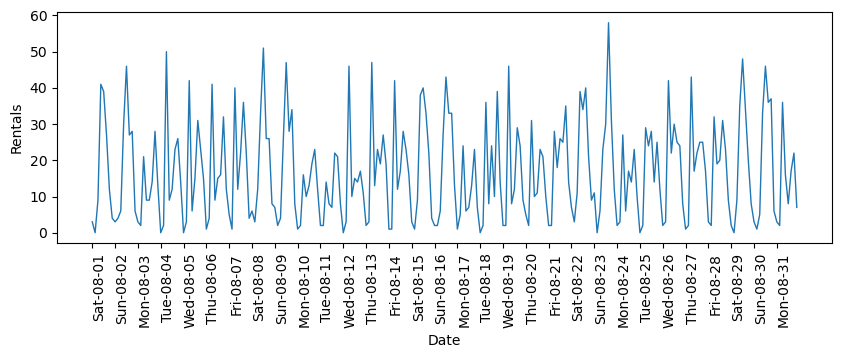

In [209]:
plt.figure(figsize=(10,3));


citibike = load_modified_citibike();

xticks = pandas.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D');

plt.xticks(xticks, xticks.strftime("%a-%m-%d"), rotation=90, ha="left");
plt.plot(citibike, linewidth=1);

plt.xlabel("Date");
plt.ylabel("Rentals");

Test : (64,)
Train : (184,)
Test-set R^2: -0.04
Train-set R^2: 0.85


<Figure size 640x480 with 0 Axes>

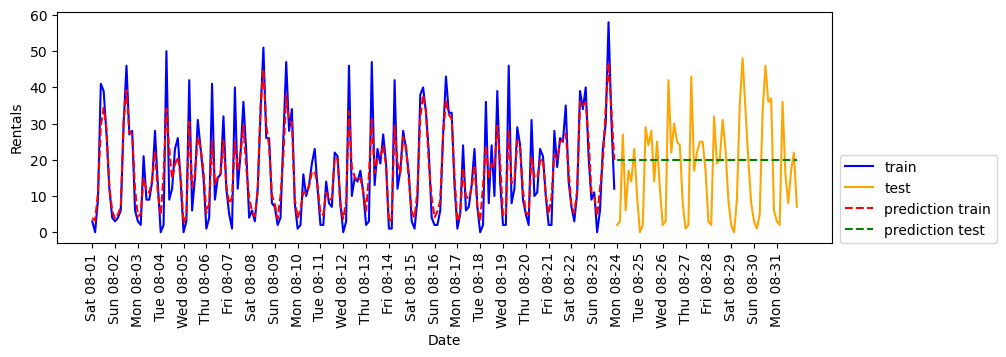

In [220]:
y = citibike.values;
X = citibike.index.astype("int64").ravel().to_numpy();

regressor = sklearn.ensemble.RandomForestRegressor(n_estimators=100, random_state=0);
n_train = 184;


plt.figure();
eval_on_features(X, y, regressor);

Test : (64,)
Train : (184,)
Test-set R^2: 0.60
Train-set R^2: 0.50


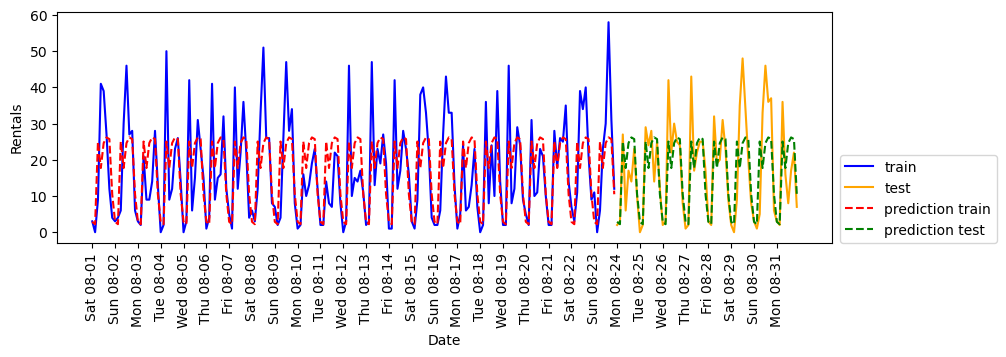

In [224]:
X_hour = citibike.index.hour.to_numpy();
eval_on_features(X_hour, y, regressor);

Test : (64,)
Train : (184,)
Test-set R^2: 0.84
Train-set R^2: 0.89


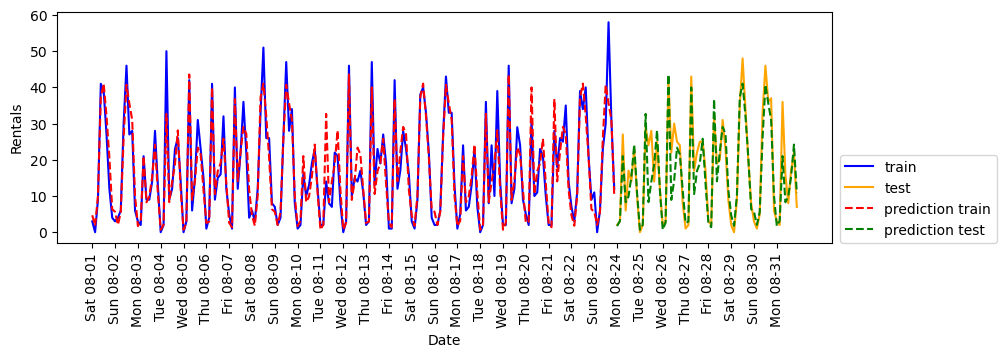

In [248]:
X_hour_week = numpy.hstack([citibike.index.dayofweek.to_numpy().reshape(-1, 1), 
                            citibike.index.hour.to_numpy().reshape(-1, 1)]);

eval_on_features(X_hour_week, y, regressor);

Test : (64,)
Train : (184,)
Test-set R^2: 0.13
Train-set R^2: 0.16


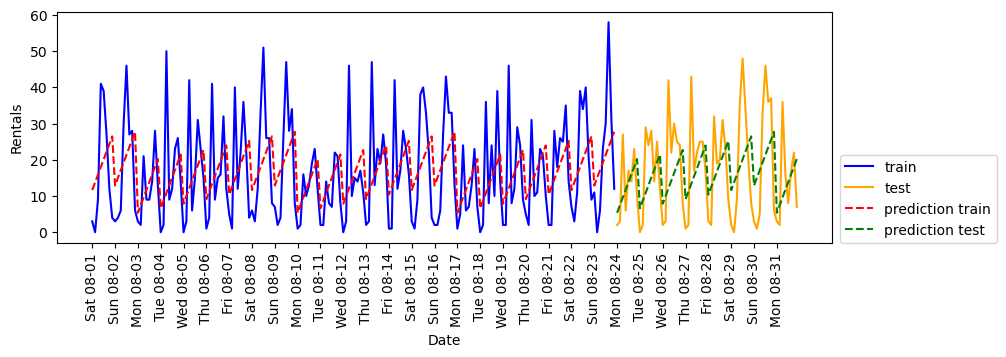

In [252]:
eval_on_features(X_hour_week, y, sklearn.linear_model.LinearRegression());

LinearRegression works much worse, and the periodic pattern looks odd. The reason for this is that we encoded day of week and time of day using integers, which are interpreted as categorical variables. Therefore, the linear model can only learn a linear function of the time of day—and it learned that later in the day, there are more rentals. However, the patterns are much more complex than that. We can capture this by interpreting the integers as categorical variables, by transforming them using One HotEncoder (see Figure 4-17):

In [257]:
X_hour_week_dummy

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

Test : (64,)
Train : (184,)
Test-set R^2: 0.61
Train-set R^2: 0.53


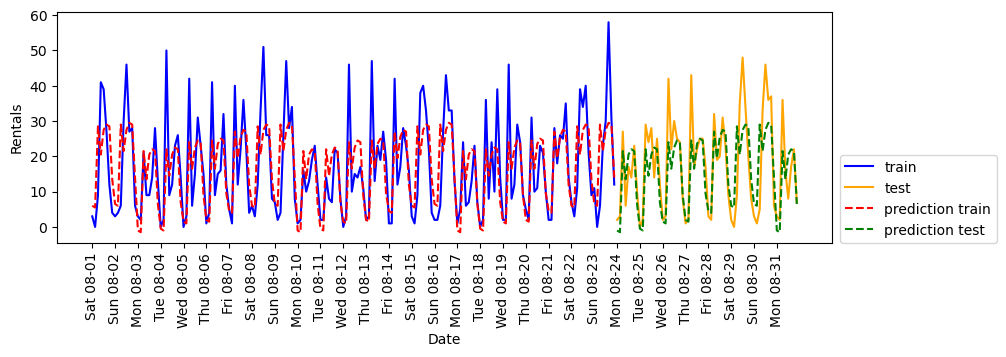

In [256]:
encoder = sklearn.preprocessing.OneHotEncoder();
X_hour_week_dummy = encoder.fit_transform(X_hour_week).toarray();

eval_on_features(X_hour_week_dummy, y, sklearn.linear_model.LinearRegression());

This gives us a much better match than the continuous feature encoding. Now the linear model learns one coefficient for each day of the week, and one coefficient for each time of the day. That means that the “time of day” pattern is shared over all days of the week, though. Using interaction features, we can allow the model to learn one coefficient for each combination of day and time of day.

In [263]:
poly_transformer.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3',
       'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10',
       'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x1^2', 'x1 x2', 'x1 x3',
       'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10',
       'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x2^2', 'x2 x3', 'x2 x4',
       'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11',
       'x2 x12', 'x2 x13', 'x2 x14', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6',
       'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13',
       'x3 x14', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9',
       'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14', 'x5^2', 'x5 x6',
       'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x5 x13',
       'x5 x14', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11',
       'x6 x12', 'x6 x13', 'x6 x14', 'x7^2', 'x7 x8', 'x7 x9

Test : (64,)
Train : (184,)
Test-set R^2: 0.85
Train-set R^2: 0.87


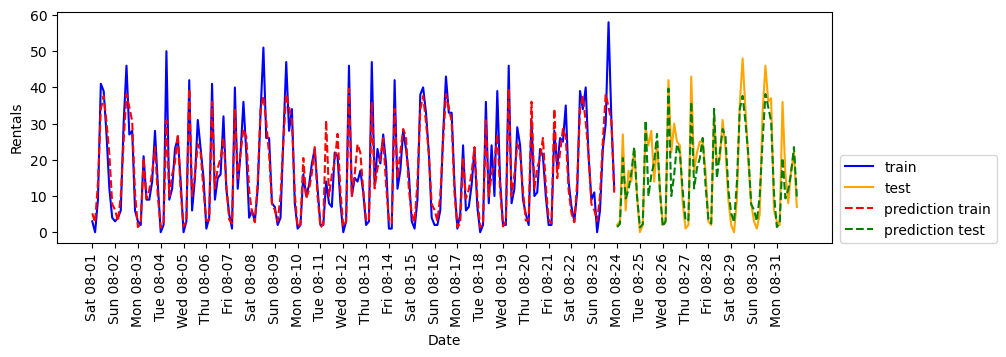

In [286]:
poly_transformer = sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=True,
                                                           include_bias=False);
X_hour_week_dummy_poly = poly_transformer.fit_transform(X_hour_week_dummy);

lr = sklearn.linear_model.Ridge();
eval_on_features(X_hour_week_dummy_poly, y, lr);

Test : (64,)
Train : (184,)
Test-set R^2: 0.84
Train-set R^2: 0.89


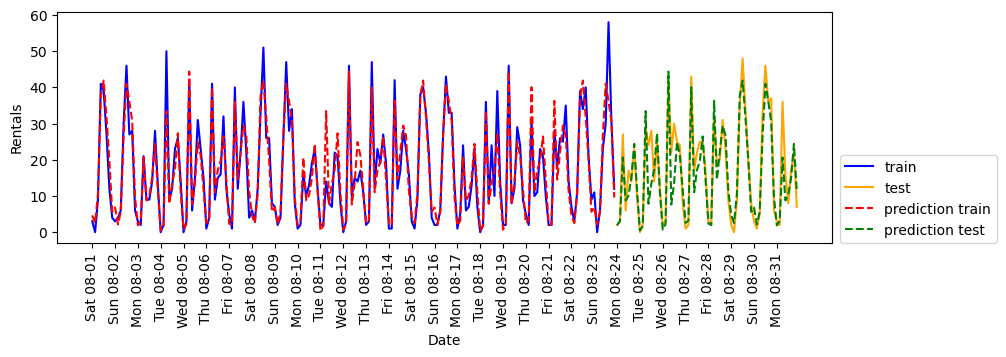

In [267]:
eval_on_features(X_hour_week_dummy_poly, y, sklearn.linear_model.LinearRegression());

In [282]:
hour = ["%02d:00" % i for i in range(0,24,3)];
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

features = day + hour;

In [294]:
poly_transformer.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4',
       'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11',
       'x0 x12', 'x0 x13', 'x0 x14', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5',
       'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12',
       'x1 x13', 'x1 x14', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7',
       'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14',
       'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10',
       'x3 x11', 'x3 x12', 'x3 x13', 'x3 x14', 'x4 x5', 'x4 x6', 'x4 x7',
       'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14',
       'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12',
       'x5 x13', 'x5 x14', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11',
       'x6 x12', 'x6 x13', 'x6 x14', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11',
       'x7 x12', 'x7 x13', 'x7 x14', 'x8 x9', 'x

In [290]:
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = numpy.array(features_poly)[lr.coef_ != 0];
coef_nonzero = lr.coef_[lr.coef_ != 0];

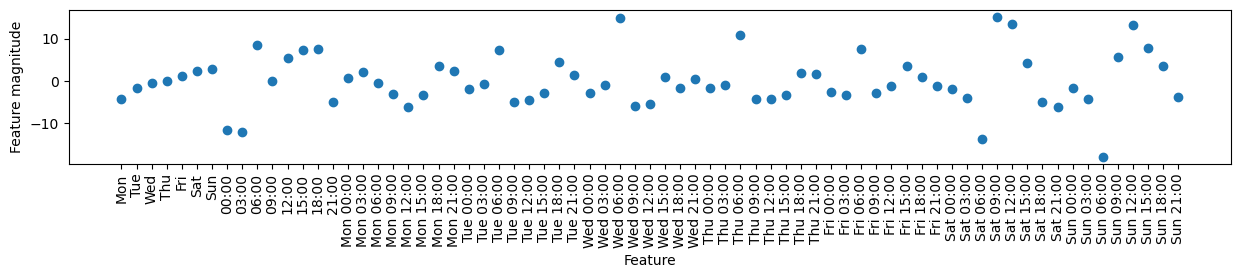

In [297]:
plt.figure(figsize=(15, 2));
plt.plot(coef_nonzero,'o');
plt.xticks(numpy.arange(len(features_nonzero)), features_nonzero, rotation=90);
plt.ylabel("Feature magnitude");
plt.xlabel("Feature");